In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import tensorflow as tf
tf.debugging.set_log_device_placement(False)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Generating reproducible results from same code
tf.random.set_seed(14)

In [3]:
forest=pd.read_csv('forestfires (1).csv')
forest.head()

month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  ...  monthfeb  \
0   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0  ...         0   
1   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0  ...         0   
2   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0  ...         0   
3   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2  ...         0   
4   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0  ...         0   

   monthjan  monthjul  monthjun  monthmar  monthmay  monthnov  monthoct  \
0         0         0         0         1         0         0         0   
1         0         0         0         0         0         0         1   
2         0         0         0         0         0         0         1   
3         0         0         0         1         0         0         0   
4         0         0         0         1         0         0         0   

   monthsep  size_category  
0         0          small  
1         0          small  
2         0          small  
3         0          small  
4         0          small  

[5 rows x 31 columns]

In [4]:
df = forest.copy() #Removing the dummies at this time
df.drop(df.columns[11:30],axis=1,inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [6]:
df.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'area', 'size_category'],
      dtype='object')

In [7]:
df.isnull().sum()

month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
size_category    0
dtype: int64

### Feature Analysis

In [8]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [9]:
# The dataset is biased. Lets remove the bias.
df.size_category.value_counts()

small    378
large    139
Name: size_category, dtype: int64

In [10]:
# Label Encoding
# We are going to perform label encoding since it is faster than dummy variables

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df.month= label_encoder.fit_transform(df.month)
df.day= label_encoder.fit_transform(df.day)
df.size_category= label_encoder.fit_transform(df.size_category)
df.head()

month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  \
0      7    0  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0   
1     10    5  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0   
2     10    2  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0   
3      7    0  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0   
4      7    3  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0   

   size_category  
0              1  
1              1  
2              1  
3              1  
4              1

### Removing Bias in the Dataset

In [11]:
from imblearn.combine import SMOTETomek
from collections import Counter

resamp = df.copy()

# SMOTEK TECHNIQUE

# Define dataset
a = resamp.iloc[:,:-1]
b = resamp.iloc[:,-1]

# Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

# Count after
print(Counter(b)) #removed bias in dataset

Counter({1: 378, 0: 139})
Counter({1: 369, 0: 369})


In [12]:
# Splitting the data into train and test
X = a
Y = b
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

### Neural Network Modelling

In [13]:
# create model
model = Sequential()
model.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
model.add(Dense(12,kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

In [14]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# Fit the model
hist = model.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=10)

Epoch 1/50


35/35 [==============================] - 3s 20ms/step - loss: 0.6943 - accuracy: 0.4464 - val_loss: 0.6932 - val_accuracy: 0.5205
Epoch 2/50
35/35 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5246 - val_loss: 0.6913 - val_accuracy: 0.5322
Epoch 3/50
35/35 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5652 - val_loss: 0.6806 - val_accuracy: 0.6257
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - loss: 0.6694 - accuracy: 0.6928 - val_loss: 0.6353 - val_accuracy: 0.7602
Epoch 5/50
35/35 [==============================] - 0s 7ms/step - loss: 0.5883 - accuracy: 0.7710 - val_loss: 0.5137 - val_accuracy: 0.7544
Epoch 6/50
35/35 [==============================] - 0s 6ms/step - loss: 0.4707 - accuracy: 0.8406 - val_loss: 0.3990 - val_accuracy: 0.8012
Epoch 7/50
35/35 [==============================] - 0s 7ms/step - loss: 0.3587 - accuracy: 0.8812 - val_loss: 0.2840 - val_accuracy: 0.9123
Epoch 8/50
35/35 

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.9910


In [17]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [18]:
hist_df = pd.DataFrame(hist.history)
hist_df["epoch"]=hist.epoch
hist_df.tail()

loss  accuracy  val_loss  val_accuracy  epoch
45  0.035729  0.988406  0.052794      0.988304     45
46  0.030184  0.988406  0.041439      0.970760     46
47  0.021830  0.997101  0.085569      0.970760     47
48  0.027293  0.991304  0.045607      0.976608     48
49  0.022766  0.994203  0.039356      0.976608     49

### Visualization

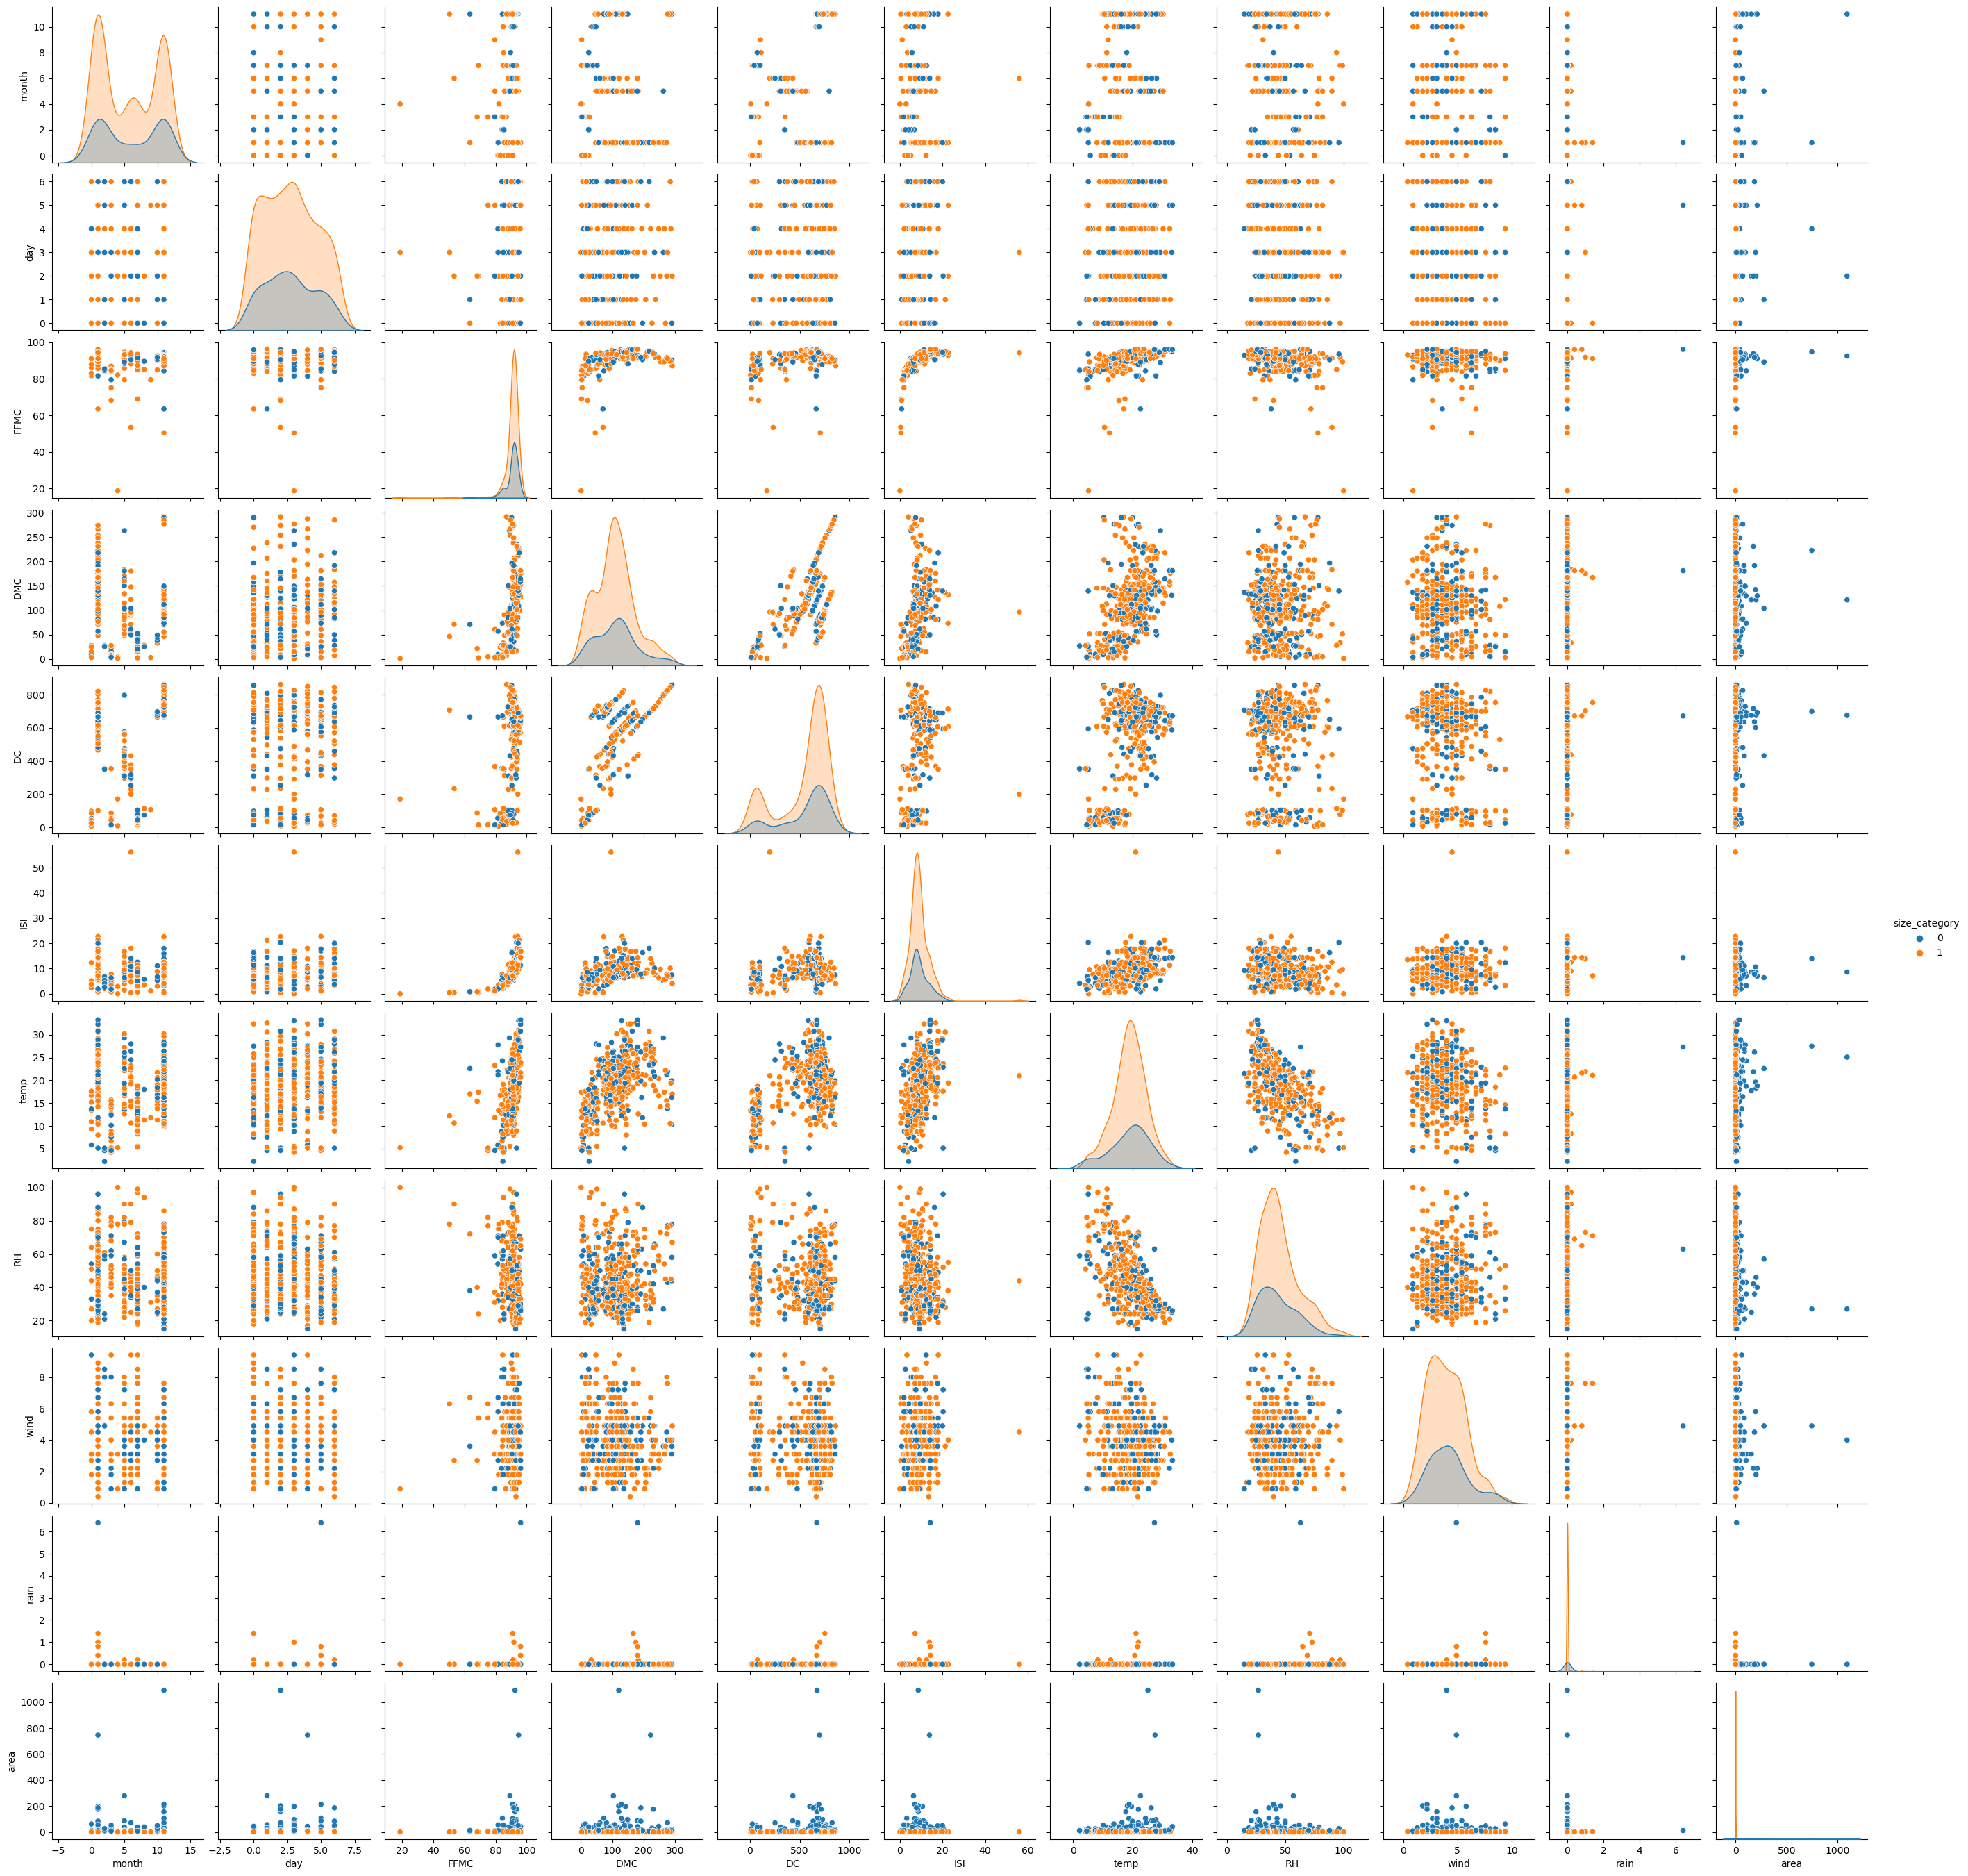

In [19]:
# Pairplot
sns.pairplot(df, hue='size_category')

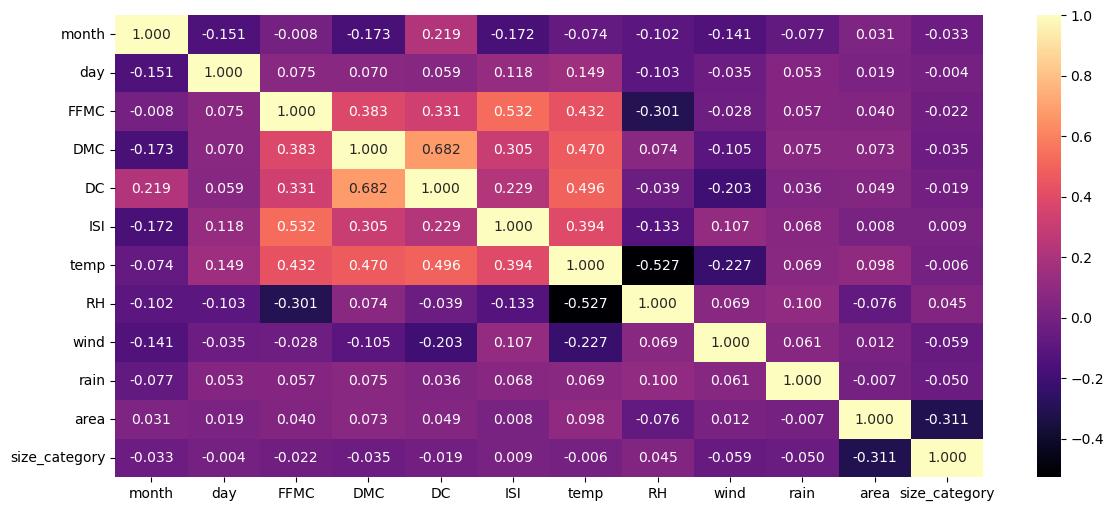

In [20]:
# Heatmap
plt.figure(figsize = (14, 6));
sns.heatmap(df.corr(), cmap='magma', annot=True, fmt=".3f")
plt.show()

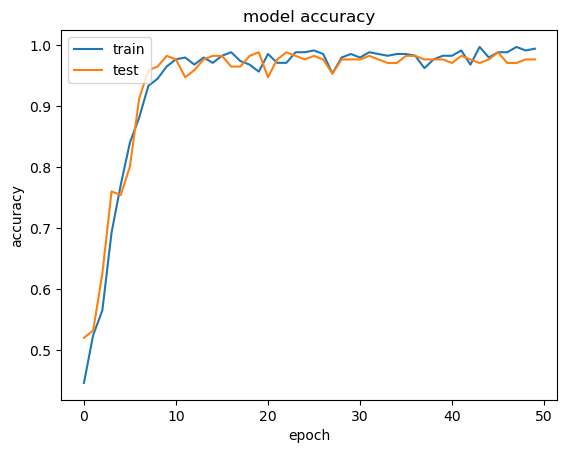

In [21]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

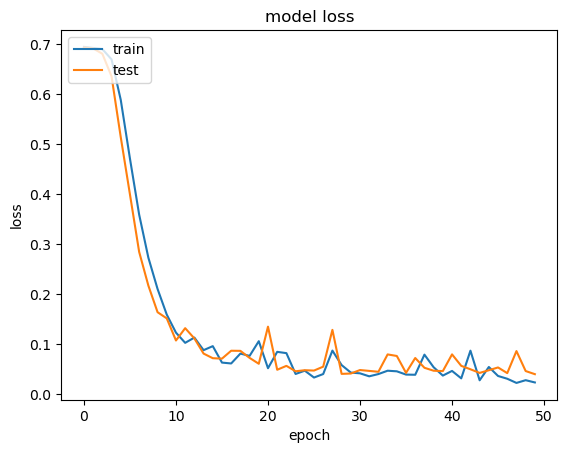

In [50]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 

### Tuning of Hyperparameters using different techniques
1. Batch Size and Epochs
2. Learning rate and Drop out rate
3. Activation Function and Kernel Initializer
4. Number of Neurons in Activation layer
5. Training model with optimum values of Hyperparameters

### 1. Batch Size and Epochs

In [51]:
pip install keras==2.12.0

Note: you may need to restart the kernel to use updated packages.


In [52]:
# Importing the necessary packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam


In [53]:
# create model
def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

    adam=Adam(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [54]:
from sklearn.preprocessing import StandardScaler
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)

### Tuning of Hyperparameters:- Learning rate and Drop out rate

In [55]:
from keras.layers import Dropout

# Defining the model
def create_model2(learning_rate,dropout_rate):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(12,input_dim = 14,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,kernel_initializer='uniform',activation = 'sigmoid'))

    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [56]:
# Create the model
model2 = KerasClassifier(build_fn = create_model2,verbose = 0,batch_size = 20,epochs = 50)

In [57]:
# Define the grid search parameters
learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]

In [58]:
# Make a dictionary of the grid search parameters
param_grids2 = dict(learning_rate = learning_rate,dropout_rate = dropout_rate)

In [59]:
# Build and fit the GridSearchCV
grid2 = GridSearchCV(estimator = model2,param_grid = param_grids2,cv = KFold(),verbose = 10)
grid_result2 = grid2.fit(X_standardized,Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 1/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.993 total time=   5.4s
[CV 2/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 2/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.980 total time=   5.3s
[CV 3/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 3/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.973 total time=   5.0s
[CV 4/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 4/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.986 total time=   5.4s
[CV 5/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 5/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.993 total time=   5.4s
[CV 1/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................
[CV 1/5; 

In [60]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
  print('{},{} with: {}'.format(mean, stdev, param))

# Best score for Dropout rate = 0.2 and learning rate is 0.001

Best : 0.9878286361694336, using {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.9851075530052185,0.00786711760605898 with: {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.9729453921318054,0.02454098642572172 with: {'dropout_rate': 0.0, 'learning_rate': 0.01}
0.9796745657920838,0.017647873132443558 with: {'dropout_rate': 0.0, 'learning_rate': 0.1}
0.9878286361694336,0.011620502508143064 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.9878102540969849,0.01311900922156369 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.959284782409668,0.04847698488780364 with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
0.9878102660179138,0.010831609361714772 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9878102540969849,0.009953013163917876 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
0.9647821307182312,0.032411285625746585 with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


### Tuning of Hyperparameters:- Activation Function and Kernel Initializer

In [61]:
# Defining the model
def create_model3(activation_function,init):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(12,input_dim = 14,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))

    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [62]:
# Create the model
model3 = KerasClassifier(build_fn = create_model3,verbose = 0,batch_size = 20,epochs = 50)

In [63]:
# Define the grid search parameters
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']

In [64]:
# Make a dictionary of the grid search parameters
param_grids3 = dict(activation_function = activation_function,init = init)

In [65]:
# Build and fit the GridSearchCV
grid3 = GridSearchCV(estimator = model3,param_grid = param_grids3,cv = KFold(),verbose = 10)
grid_result3 = grid3.fit(X_standardized,Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 1/5; 1/12] END activation_function=softmax, init=uniform;, score=0.041 total time=   4.7s
[CV 2/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 2/5; 1/12] END activation_function=softmax, init=uniform;, score=0.838 total time=   5.2s
[CV 3/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 3/5; 1/12] END activation_function=softmax, init=uniform;, score=0.466 total time=   5.7s
[CV 4/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 4/5; 1/12] END activation_function=softmax, init=uniform;, score=0.633 total time=   6.9s
[CV 5/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 5/5; 1/12] END activation_function=softmax, init=uniform;, score=0.211 total time=   7.5s
[CV 1/5; 2/12] START activation_function=softmax, init=normal...

[CV 3/5; 10/12] END activation_function=linear, init=uniform;, score=0.980 total time=   5.8s
[CV 4/5; 10/12] START activation_function=linear, init=uniform..................
[CV 4/5; 10/12] END activation_function=linear, init=uniform;, score=0.980 total time=   5.8s
[CV 5/5; 10/12] START activation_function=linear, init=uniform..................
[CV 5/5; 10/12] END activation_function=linear, init=uniform;, score=1.000 total time=   5.8s
[CV 1/5; 11/12] START activation_function=linear, init=normal...................
[CV 1/5; 11/12] END activation_function=linear, init=normal;, score=1.000 total time=   5.9s
[CV 2/5; 11/12] START activation_function=linear, init=normal...................
[CV 2/5; 11/12] END activation_function=linear, init=normal;, score=0.993 total time=   5.9s
[CV 3/5; 11/12] START activation_function=linear, init=normal...................
[CV 3/5; 11/12] END activation_function=linear, init=normal;, score=0.973 total time=   5.4s
[CV 4/5; 11/12] START activation_f

In [66]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means3 = grid_result3.cv_results_['mean_test_score']
stds3 = grid_result3.cv_results_['std_test_score']
params3 = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
  print('{},{} with: {}'.format(mean, stdev, param))

# Best activation function in our case would be Relu and Kernel Initializer is Uniform

Best : 0.9918735027313232, using {'activation_function': 'relu', 'init': 'uniform'}
0.43762639313936236,0.2856960240168943 with: {'activation_function': 'softmax', 'init': 'uniform'}
0.4335447706282139,0.2720247475625944 with: {'activation_function': 'softmax', 'init': 'normal'}
0.39279279112815857,0.3394782983061473 with: {'activation_function': 'softmax', 'init': 'zero'}
0.9918735027313232,0.007892353714541292 with: {'activation_function': 'relu', 'init': 'uniform'}
0.9891616106033325,0.006892467794511547 with: {'activation_function': 'relu', 'init': 'normal'}
0.2044033885002136,0.18511260144237904 with: {'activation_function': 'relu', 'init': 'zero'}
0.9891616106033325,0.009193897020330837 with: {'activation_function': 'tanh', 'init': 'uniform'}
0.9878102540969849,0.01311900922156369 with: {'activation_function': 'tanh', 'init': 'normal'}
0.2044033885002136,0.18511260144237904 with: {'activation_function': 'tanh', 'init': 'zero'}
0.9891616106033325,0.009193897020330837 with: {'activ

### Tuning of Hyperparameter :- Number of Neurons in activation layer

In [67]:
# Defining the model

def create_model4(neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))

    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [68]:
# Create the model
model4 = KerasClassifier(build_fn = create_model4,verbose = 0,batch_size = 20,epochs = 50)

In [69]:
# Define the grid search parameters
neuron1 = [4,8,14]
neuron2 = [4,8,12]

In [70]:
# Make a dictionary of the grid search parameters
param_grids4 = dict(neuron1 = neuron1,neuron2 = neuron2)

In [71]:
# Build and fit the GridSearchCV
grid4 = GridSearchCV(estimator = model4,param_grid = param_grids4,cv = KFold(),verbose = 10)
grid_result4 = grid4.fit(X_standardized,Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.993 total time=   5.7s
[CV 2/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 2/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.986 total time=   5.8s
[CV 3/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 3/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.932 total time=   5.7s
[CV 4/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 4/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.973 total time=   5.6s
[CV 5/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 5/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.912 total time=   5.7s
[CV 1/5; 2/9] START neuron1=4, neuron2=8........................................
[CV 1/5; 2/9] END .........neuron1=4, neuron2=8;,

In [72]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result4.best_score_,grid_result4.best_params_))
means4 = grid_result4.cv_results_['mean_test_score']
stds4 = grid_result4.cv_results_['std_test_score']
params4 = grid_result4.cv_results_['params']
for mean, stdev, param in zip(means4, stds4, params4):
  print('{},{} with: {}'.format(mean, stdev, param))

#Best results are Neuron 1 = 4 and Neuron 2 = 4

Best : 0.9878010749816895, using {'neuron1': 14, 'neuron2': 4}
0.9593031764030456,0.03185509235245566 with: {'neuron1': 4, 'neuron2': 4}
0.9823680758476258,0.011039729051023137 with: {'neuron1': 4, 'neuron2': 8}
0.9674388647079468,0.027606530725180507 with: {'neuron1': 4, 'neuron2': 12}
0.9823680758476258,0.012565829829719025 with: {'neuron1': 8, 'neuron2': 4}
0.9878010630607605,0.007901886658557823 with: {'neuron1': 8, 'neuron2': 8}
0.9864405155181885,0.009601157750802738 with: {'neuron1': 8, 'neuron2': 12}
0.9878010749816895,0.008969495533658898 with: {'neuron1': 14, 'neuron2': 4}
0.9851167321205139,0.01976104246955382 with: {'neuron1': 14, 'neuron2': 8}
0.9864681005477905,0.017619502943822436 with: {'neuron1': 14, 'neuron2': 12}


### Hyperparameters all at once
The hyperparameter optimization was carried out by taking 2 hyperparameters at once. We may have missed the best values. The performance can be further improved by finding the optimum values of hyperparameters all at once given by the code snippet below.

In [73]:
# Defining the model
def create_model_fnl():
    model = Sequential()
    model.add(Dense(4,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,input_dim = 4,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))

    adam = Adam(lr = 0.001) #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [74]:
# Create the model
model_fnl = KerasClassifier(build_fn = create_model_fnl,verbose = 0,batch_size = 20,epochs = 50)

In [75]:
# Splitting the data into training and Testing Data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_standardized,Y, test_size = 0.3)

In [76]:
# Fitting the model
hist2 = model_fnl.fit(X_train_1,y_train_1)

In [77]:
from sklearn.metrics import confusion_matrix,classification_report
def report_model(model):
    model_preds = model.predict(X_test_1)
    print(confusion_matrix(y_test_1,model_preds))
    print(classification_report(y_test_1,model_preds))
report_model(model_fnl)

7/7 [==============================] - 0s 2ms/step
[[108   6]
 [  0 108]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       114
           1       0.95      1.00      0.97       108

    accuracy                           0.97       222
   macro avg       0.97      0.97      0.97       222
weighted avg       0.97      0.97      0.97       222

